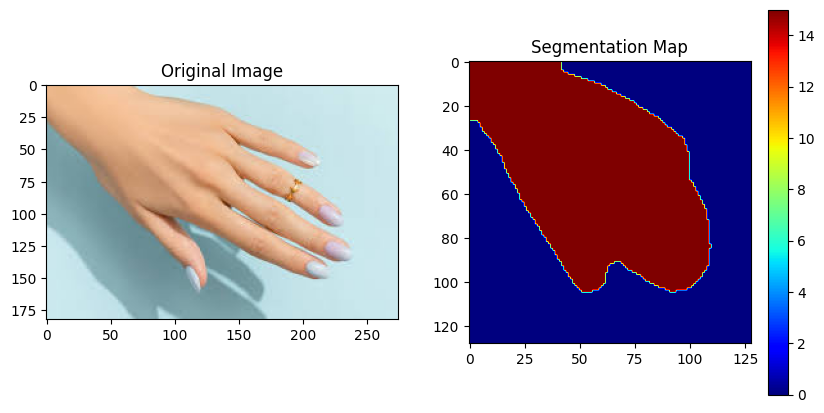

In [ ]:
import torch
import numpy as np
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

model = torch.jit.load("deeplabv3_scripted_model.pt")
model.eval()

def preprocess_image(image_path: str) -> torch.Tensor:
    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0)

def postprocess_output(output: torch.Tensor) -> np.ndarray:
    output = torch.argmax(output['out'], dim=1).squeeze(0).cpu().numpy()
    return output

image_path = "test_image.jpeg"

input_tensor = preprocess_image(image_path)
with torch.no_grad():
    output = model(input_tensor)

segmentation_map = postprocess_output(output)

original_image = Image.open(image_path)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title("Segmentation Map")
plt.imshow(segmentation_map, cmap="jet")
plt.colorbar()
plt.show()


In [ ]:
import time

start_time = time.time()
with torch.no_grad():
    output = model(input_tensor)
end_time = time.time()

print(f"추론 시간: {end_time - start_time:.4f}초")


추론 시간: 0.7234초


In [ ]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset

class SegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_names = os.listdir(image_dir)

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_names[idx])
        mask_path = os.path.join(self.mask_dir, self.image_names[idx])
        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


100%|██████████| 2.00G/2.00G [02:06<00:00, 15.8MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Image size: (500, 281)
Target size: (500, 281)


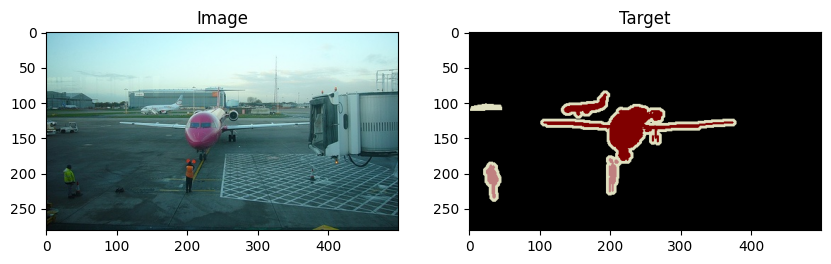

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch

# VOC 데이터셋 다운로드 및 로드
dataset = datasets.VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=True,
    transforms=None
)

image, target = dataset[0]
print("Image size:", image.size)
print("Target size:", target.size)

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Target")
plt.imshow(target)
plt.show()


In [ ]:
from torchvision import transforms

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = datasets.VOCSegmentation(
    root="./data",
    year="2012",
    image_set="train",
    download=True,
    transforms=lambda image, mask: (image_transform(image), mask_transform(mask))
)

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
import torch
from torchvision.models.segmentation import deeplabv3_resnet50

num_classes = 21
model = deeplabv3_resnet50(pretrained=True)
model.classifier[4] = torch.nn.Conv2d(256, num_classes, kernel_size=(1, 1))

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 학습 루프
for epoch in range(10):
    model.train()
    total_loss = 0

    for images, masks in train_loader:

        images, masks = images.to(device), masks.long().to(device)

        masks = masks.squeeze(1)  # [B, 1, H, W] -> [B, H, W] 형태로 변환

        outputs = model(images)["out"]

        loss = criterion(outputs, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/10], Loss: {total_loss:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 150MB/s]


Epoch [1/10], Loss: 297.5767
Epoch [2/10], Loss: 100.1672
Epoch [3/10], Loss: 55.1438
Epoch [4/10], Loss: 43.4368
Epoch [5/10], Loss: 38.1258
Epoch [6/10], Loss: 34.1761
Epoch [7/10], Loss: 31.0201
Epoch [8/10], Loss: 29.0664
Epoch [9/10], Loss: 27.0495
Epoch [10/10], Loss: 25.7760


In [ ]:
scripted_model = torch.jit.script(model)
scripted_model.save("deeplabv3_scripted_model.pt")
print("TorchScript 모델 저장 완료!")


/usr/local/lib/python3.10/dist-packages/torch/jit/_recursive.py:313: UserWarning: 'aux_classifier' was found in ScriptModule constants,  but it is a non-constant submodule. Consider removing it.
  warnings.warn(


TorchScript 모델 저장 완료!


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


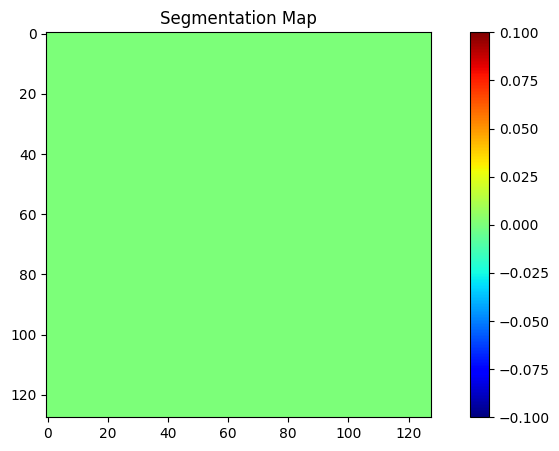

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt

class VOCTransform:
    def __init__(self, image_transform):
        self.image_transform = image_transform

    def __call__(self, img, target):
        img = self.image_transform(img)
        return img, target

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform = VOCTransform(image_transform)

dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="val",
    download=True,
    transforms=custom_transform
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model = torch.jit.load("deeplabv3_scripted_model.pt")
scripted_model.to(device)
scripted_model.eval()

test_image, _ = dataset[0]
test_image = test_image.unsqueeze(0).to(device)

with torch.no_grad():
    output = scripted_model(test_image)

segmentation_map = torch.argmax(output["out"], dim=1).squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.title("Segmentation Map")
plt.imshow(segmentation_map, cmap="jet")
plt.colorbar()
plt.show()


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Test image shape: torch.Size([1, 3, 128, 128])
Test image min: -2.1179039478302
Test image max: 2.552854299545288
Output shape: torch.Size([1, 21, 128, 128])
Output min: -5.093621253967285
Output max: 5.273107528686523


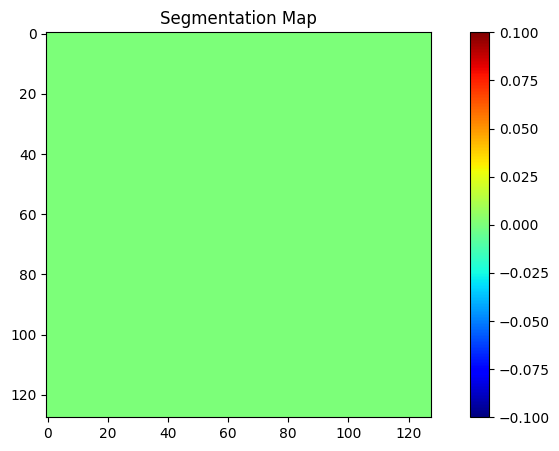

In [ ]:
import torch
from torchvision import transforms
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt

class VOCTransform:
    def __init__(self, image_transform):
        self.image_transform = image_transform

    def __call__(self, img, target):
        img = self.image_transform(img)
        return img, target

image_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

custom_transform = VOCTransform(image_transform)

dataset = VOCSegmentation(
    root="./data",
    year="2012",
    image_set="val",
    download=True,
    transforms=custom_transform
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scripted_model = torch.jit.load("deeplabv3_scripted_model.pt")
scripted_model.to(device)
scripted_model.eval()

test_image, _ = dataset[0]
test_image = test_image.unsqueeze(0).to(device)

print("Test image shape:", test_image.shape)
print("Test image min:", test_image.min().item())
print("Test image max:", test_image.max().item())

with torch.no_grad():
    output = scripted_model(test_image)

print("Output shape:", output["out"].shape)
print("Output min:", output["out"].min().item())
print("Output max:", output["out"].max().item())

segmentation_map = torch.argmax(output["out"], dim=1).squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.title("Segmentation Map")
plt.imshow(segmentation_map, cmap="jet")
plt.colorbar()
plt.show()
